In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
import os
import random

from torch import nn

from sklearn.metrics import mean_squared_error
from hython.preprocess import preprocess, apply_normalization
from hython.datasets.datasets import LSTMDataset
from hython.train_val import train_val
from hython.sampler import RegularIntervalSampler, SpaceSampler
from hython.metrics import mse_metric

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset


from hython.utils import missing_location_idx, reconstruct_from_missing

from hython.models.lstm import CustomLSTM


# viz
import matplotlib.pyplot as plt
#import hvplot.xarray 
from hython.viz import plot_sampler
from hython.utils import predict, prepare_for_plotting
from hython.viz import map_bias, map_pbias, map_pearson, map_at_timesteps, ts_compare

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(2023)

/home/iacopo/.local/build/mambaforge/envs/dl-pytorch/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [158]:
wd = Path("../data/datademo")
fp_dynamic_forcings = wd / "forcings.nc"
fp_wflow_static_params = wd / "staticmaps.nc"
fp_target = wd / "output.nc"


dynamic_names = ["precip", "pet", "temp"]
static_names = [ 'M', 'thetaS', 'RootingDepth', 'Kext', 'Sl', 'Swood', 'TT', 'KsatHorFrac'] 
target_names = [ "vwc", "actevap" ]

timeslice = slice("2016-01-01","2020-12-31")

### HYPERPARAMETERS

# training 

spatial_batch_size = 128*4
temporal_sampling_size = 200
seq_length = 80

# model 

hidden_size = 8

model_params={
    "input_size": 3, #number of dynamic predictors - user_input
    "hidden_size": hidden_size, # user_input
    "output_size": len(target_names), # number_target - user_input
    "number_static_predictors": len(static_names), #number of static parameters - user_input 

}

## The used device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
forcings = xr.open_dataset( fp_dynamic_forcings).rename({"latitude":"lat", "longitude":"lon"})
params = xr.open_dataset(fp_wflow_static_params ).rename({"latitude":"lat", "longitude":"lon"})
targets = xr.open_dataset(fp_target).isel(lat=slice(None, None, -1))
targets

In [159]:
if timeslice:
    forcings = forcings.sel(time=timeslice)
    targets = targets.sel(time=timeslice)

# Time

In [177]:
Xd, Xs, Y, *_ = preprocess(
                forcings, 
                   params, 
                   targets, 
                   dynamic_name = dynamic_names,
                   static_name = static_names, 
                   target_name = target_names
                   )

dynamic:  (1452, 1827, 3)  => (GRIDCELL, TIME, FEATURE)
static:  (1452, 8)  => (GRIDCELL, FEATURE)
target:  (1452, 1827, 2)  => (GRIDCELL, TIME, TARGET)


In [178]:
#  train valid split by time
Xd_train = Xd[:,:1500,:]
Xd_val = Xd[:,1500:,:]
Y_train = Y[:,:1500,:]
Y_val = Y[:,1500:,:]

Xd_train.shape, Xd_val.shape, Y_train.shape, Y_val.shape

((1452, 1500, 3), (1452, 327, 3), (1452, 1500, 2), (1452, 327, 2))

In [179]:
# normalization
Xd_train, d_m, d_std = apply_normalization(Xd_train, type = "spacetime", how ='standard')

Xd_val = apply_normalization(Xd_val, type = "spacetime", how ='standard', m1 = d_m, m2 = d_std)

Xs, s_m, s_std = apply_normalization(Xs, type = "space", how ='standard')

Y_train, m1, m2 = apply_normalization(Y_train, type = "spacetime", how ='standard')

Y_val = apply_normalization(Y_val, type = "spacetime", how ='standard', m1 = m1, m2 = m2)

In [180]:
Xd_train.shape, Xd_val.shape, Y_train.shape, Y_val.shape, Xs.shape

((1452, 1500, 3), (1452, 327, 3), (1452, 1500, 2), (1452, 327, 2), (1452, 8))

In [181]:
Xs = torch.Tensor(Xs)

Xd_train = torch.Tensor(Xd_train)
Xd_val = torch.Tensor(Xd_val)

Y_train = torch.Tensor(Y_train)
Y_val = torch.Tensor(Y_val)

In [182]:
train_dataset = LSTMDataset(Xd_train, Y_train, Xs)
valid_dataset = LSTMDataset(Xd_val, Y_val, Xs)

In [183]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_dataset , batch_size=64, shuffle=False)

In [184]:
model = CustomLSTM(model_params)
model = model.to(device)
model

CustomLSTM(
  (fc0): Linear(in_features=11, out_features=8, bias=True)
  (lstm): LSTM(8, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [185]:
# Training and validation 
path2models= "./checkpoints" #./output/kaggle/working/AI4EO/models
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
## Where to save the trained models weights 
## Set the optimization algorithms and learning rate
opt = optim.Adam(model.parameters(), lr=1e-2)

## Set the loss function
loss_fn = nn.MSELoss()

## Set the metric function - here using the same loss function 
metric_fn = mse_metric #nn.MSELoss()

## Set the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10)

epochs = 10

## Set the training parameters
params_train={
    "num_epochs": epochs,
    "temporal_sampling_size": temporal_sampling_size,
    "seq_length": seq_length,
    "ts_range": Y.shape[1],
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt",
    "device":device,
    "target_names":target_names

}

In [186]:
model, sm_loss_history ,sm_metric_history = train_val(model, params_train)

Epoch 0/9, current lr=0.01


RuntimeError: Expected sequence length to be larger than 0 in RNN

# Space

In [64]:
X = forcings.to_dataarray().transpose("lat","lon", "time", "variable")

In [61]:
# remove missing before sampling and reshaping? 
# if removing after then the sampling indices may hit a indexing error as they were computed before remove missing

In [62]:
# initialize samplers
spatial_train_sampler = RegularIntervalSampler(
                                 intervals = (5,5),
                                 origin = (1,1)
                    )
spatial_val_sampler = RegularIntervalSampler(
                                 intervals = (5,5),
                                 origin = (3,3)
                    ) 

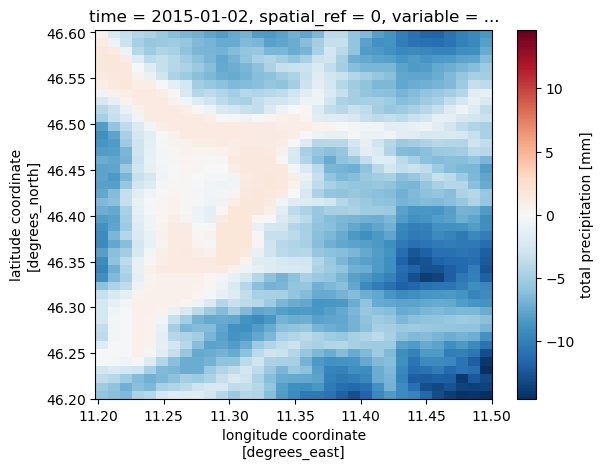

In [63]:
X.isel(time=1, variable=2).plot()

In [ ]:
# return  indices of sampled cells
_, X_train_meta = spatial_train_sampler.sampling(X.values)
_, X_val_meta = spatial_val_sampler.sampling(X.values)

In [11]:
X_train_meta.idx_sampled_1d, X_val_meta.idx_sampled_1d

(array([  34,   39,   44,   49,   54,   59,   64,  199,  204,  209,  214,
         219,  224,  229,  364,  369,  374,  379,  384,  389,  394,  529,
         534,  539,  544,  549,  554,  559,  694,  699,  704,  709,  714,
         719,  724,  859,  864,  869,  874,  879,  884,  889, 1024, 1029,
        1034, 1039, 1044, 1049, 1054, 1189, 1194, 1199, 1204, 1209, 1214,
        1219, 1354, 1359, 1364, 1369, 1374, 1379, 1384]),
 array([ 102,  107,  112,  117,  122,  127,  267,  272,  277,  282,  287,
         292,  432,  437,  442,  447,  452,  457,  597,  602,  607,  612,
         617,  622,  762,  767,  772,  777,  782,  787,  927,  932,  937,
         942,  947,  952, 1092, 1097, 1102, 1107, 1112, 1117, 1257, 1262,
        1267, 1272, 1277, 1282, 1422, 1427, 1432, 1437, 1442, 1447]))

In [19]:
# reshape for training

Xd, Xs, Y, *_ = preprocess(
                forcings, 
                   params, 
                   targets, 
                   dynamic_name = dynamic_names,
                   static_name = static_names, 
                   target_name = target_names
                   )


dynamic:  (1452, 1827, 3)  => (GRIDCELL, TIME, FEATURE)
static:  (1452, 8)  => (GRIDCELL, FEATURE)
target:  (1452, 1827, 2)  => (GRIDCELL, TIME, TARGET)


In [ ]:
# Normalizing

Xd[X_train_meta.idx_sampled_1d], d_m, d_std = apply_normalization(Xd[X_train_meta.idx_sampled_1d], type = "spacetime", how ='standard')
Xs[X_train_meta.idx_sampled_1d], s_m, s_std = apply_normalization(Xs[X_train_meta.idx_sampled_1d], type = "space", how ='standard')

#Y_clean, y_m, y_std = apply_normalization(Y_clean, type = "spacetime", how ='standard')

Xd[X_val_meta.idx_sampled_1d] = apply_normalization(Xd[X_val_meta.idx_sampled_1d], type = "spacetime", how ='standard', m1 = d_m, m2 = d_std)
Xs[X_val_meta.idx_sampled_1d] = apply_normalization(Xs[X_val_meta.idx_sampled_1d], type = "space", how ='standard', m1 = s_m, m2 = s_std)

In [36]:
Xs = torch.Tensor(Xs)
Xd = torch.Tensor(Xd)
Y = torch.Tensor(Y)

In [37]:
# init datasets
dataset = LSTMDataset(Xd, Y, Xs)

In [38]:
train_sampler = SpaceSampler(dataset, num_samples=5, sampling_indices = X_train_meta.idx_sampled_1d.tolist())
valid_sampler = SpaceSampler(dataset, num_samples=5, sampling_indices = X_val_meta.idx_sampled_1d.tolist())

In [39]:
train_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False, sampler = train_sampler) # implement shuffling in the sampler!
val_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False, sampler = valid_sampler)

In [40]:
model = CustomLSTM(model_params)
model = model.to(device)
model


CustomLSTM(
  (fc0): Linear(in_features=11, out_features=8, bias=True)
  (lstm): LSTM(8, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [41]:
# Training and validation 
path2models= "./checkpoints" #./output/kaggle/working/AI4EO/models
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
## Where to save the trained models weights 
## Set the optimization algorithms and learning rate
opt = optim.Adam(model.parameters(), lr=1e-2)

## Set the loss function
loss_fn = nn.MSELoss()

## Set the metric function - here using the same loss function 
metric_fn = mse_metric #nn.MSELoss()

## Set the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10)

epochs = 10

## Set the training parameters
params_train={
    "num_epochs": epochs,
    "temporal_sampling_size": temporal_sampling_size,
    "seq_length": seq_length,
    "ts_range": Y.shape[1],
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt",
    "device":device,
    "target_names":target_names

}

In [42]:
model, sm_loss_history ,sm_metric_history = train_val(model, params_train)

Epoch 0/9, current lr=0.01
Copied best model weights!
train loss: 0.0010611402103677392, train metric: {'vwc': 0.005214834, 'actevap': 0.043698683}
val loss: 0.005252499133348465, val metric: {'vwc': 0.05164933, 'actevap': 0.23081844}
----------
Epoch 1/9, current lr=0.01
train loss: 0.00044268034980632365, train metric: {'vwc': 0.0026292729, 'actevap': 0.017776176}
val loss: 0.0056471554562449455, val metric: {'vwc': 0.0030765794, 'actevap': 0.30061486}
----------
Epoch 2/9, current lr=0.01
Copied best model weights!
train loss: 0.00043052624096162617, train metric: {'vwc': 0.002507135, 'actevap': 0.017338071}
val loss: 0.0048926882445812225, val metric: {'vwc': 0.003335277, 'actevap': 0.25978258}
----------
Epoch 3/9, current lr=0.01
train loss: 0.0004181513504590839, train metric: {'vwc': 0.0024418344, 'actevap': 0.016832951}
val loss: 0.013677682727575302, val metric: {'vwc': 0.018322749, 'actevap': 0.71723247}
----------
Epoch 4/9, current lr=0.01
train loss: 0.0003821263671852648

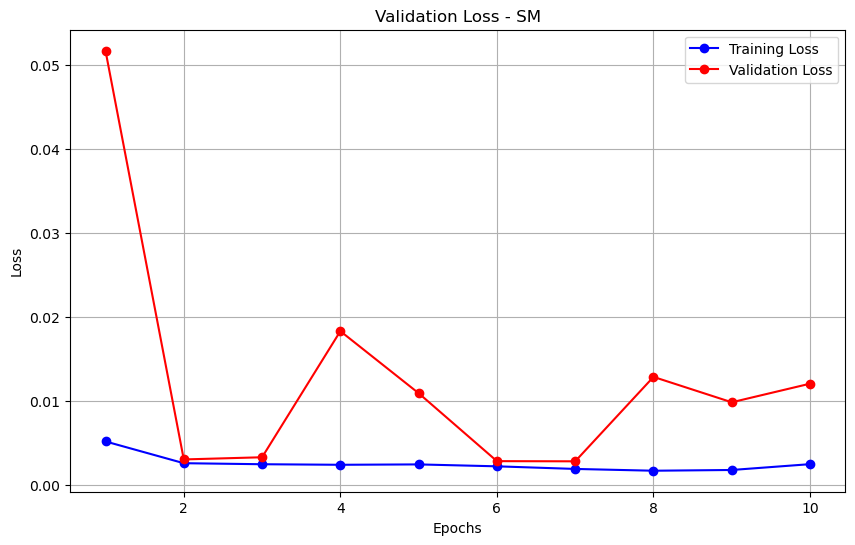

In [43]:
# import matplotlib.pyplot as plt
# Extract the loss values
train_loss = sm_metric_history["train_vwc"]
val_loss = sm_metric_history["val_vwc"]

# Create a list of epochs for the x-axis (e.g., [1, 2, 3, ..., 100])
lepochs = list(range(1,params_train["num_epochs"] + 1))

# Create the train and validation loss plots
plt.figure(figsize=(10, 6))
plt.plot(lepochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(lepochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Validation Loss - SM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

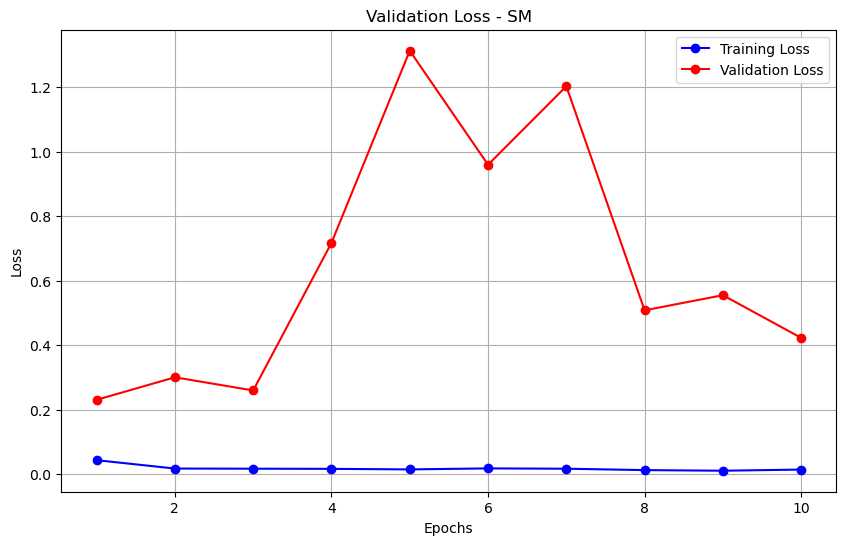

In [44]:
# import matplotlib.pyplot as plt
# Extract the loss values
train_loss = sm_metric_history["train_actevap"]
val_loss = sm_metric_history["val_actevap"]

# Create a list of epochs for the x-axis (e.g., [1, 2, 3, ..., 100])
lepochs = list(range(1,params_train["num_epochs"] + 1))

# Create the train and validation loss plots
plt.figure(figsize=(10, 6))
plt.plot(lepochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(lepochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Validation Loss - SM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

### Inference

In [45]:
Xd_all, Xs_all, Y_all, *_  = preprocess(forcings, 
                   params, 
                   targets, 
                   dynamic_name = dynamic_names,
                   static_name = static_names, 
                   target_name = target_names
                   )

dynamic:  (1452, 1827, 3)  => (GRIDCELL, TIME, FEATURE)
static:  (1452, 8)  => (GRIDCELL, FEATURE)
target:  (1452, 1827, 2)  => (GRIDCELL, TIME, TARGET)


In [46]:
# inference 
yhat = predict(Xd_all, Xs_all, model, spatial_batch_size, device)
yhat.shape

(1452, 1827, 2)

In [47]:
lat, lon, time = X.shape[:-1]
lat*lon ,time

(1452, 1827)

In [48]:
y_target, y_pred = prepare_for_plotting(y_target=Y_all[:,:,[1]], y_pred = yhat[:,:,[1]], shape = (lat, lon, time), coords = targets.coords)
y_target.shape

(44, 33, 1827)

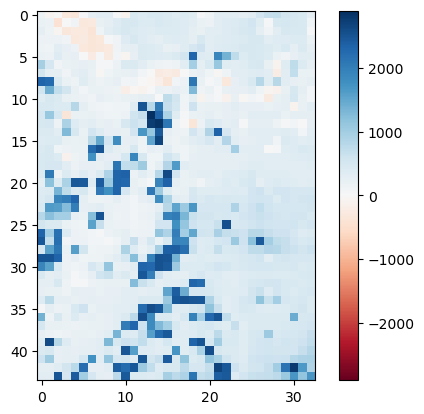

In [49]:
map_bias(y_target, y_pred)

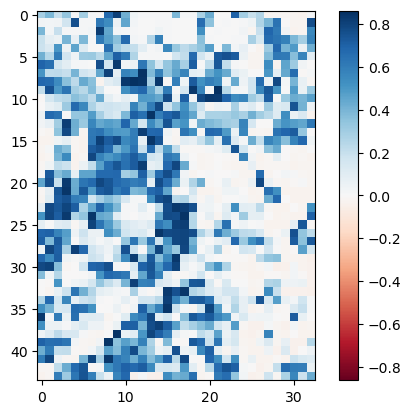

In [50]:
map_pearson(y_target, y_pred)

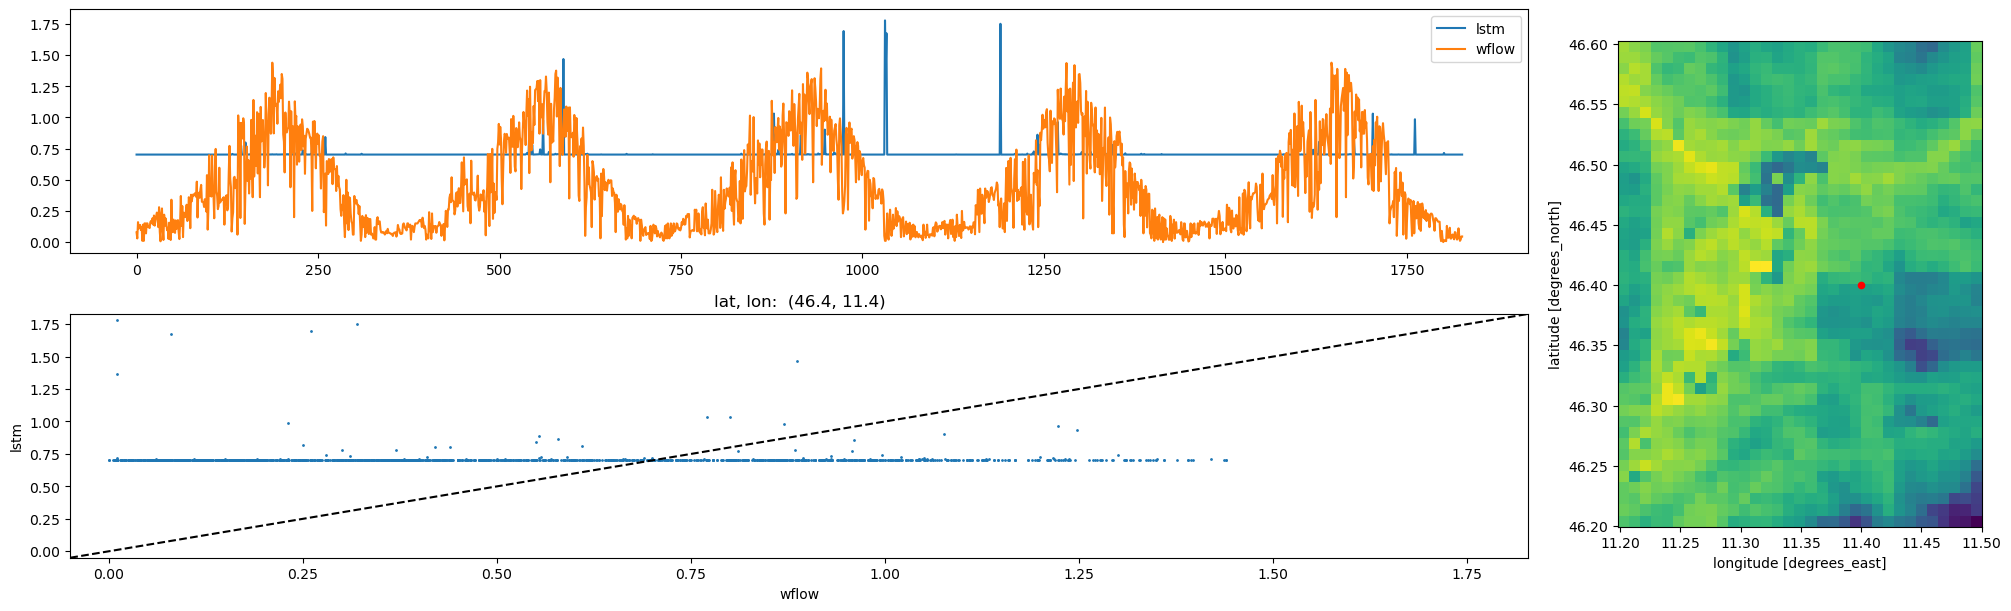

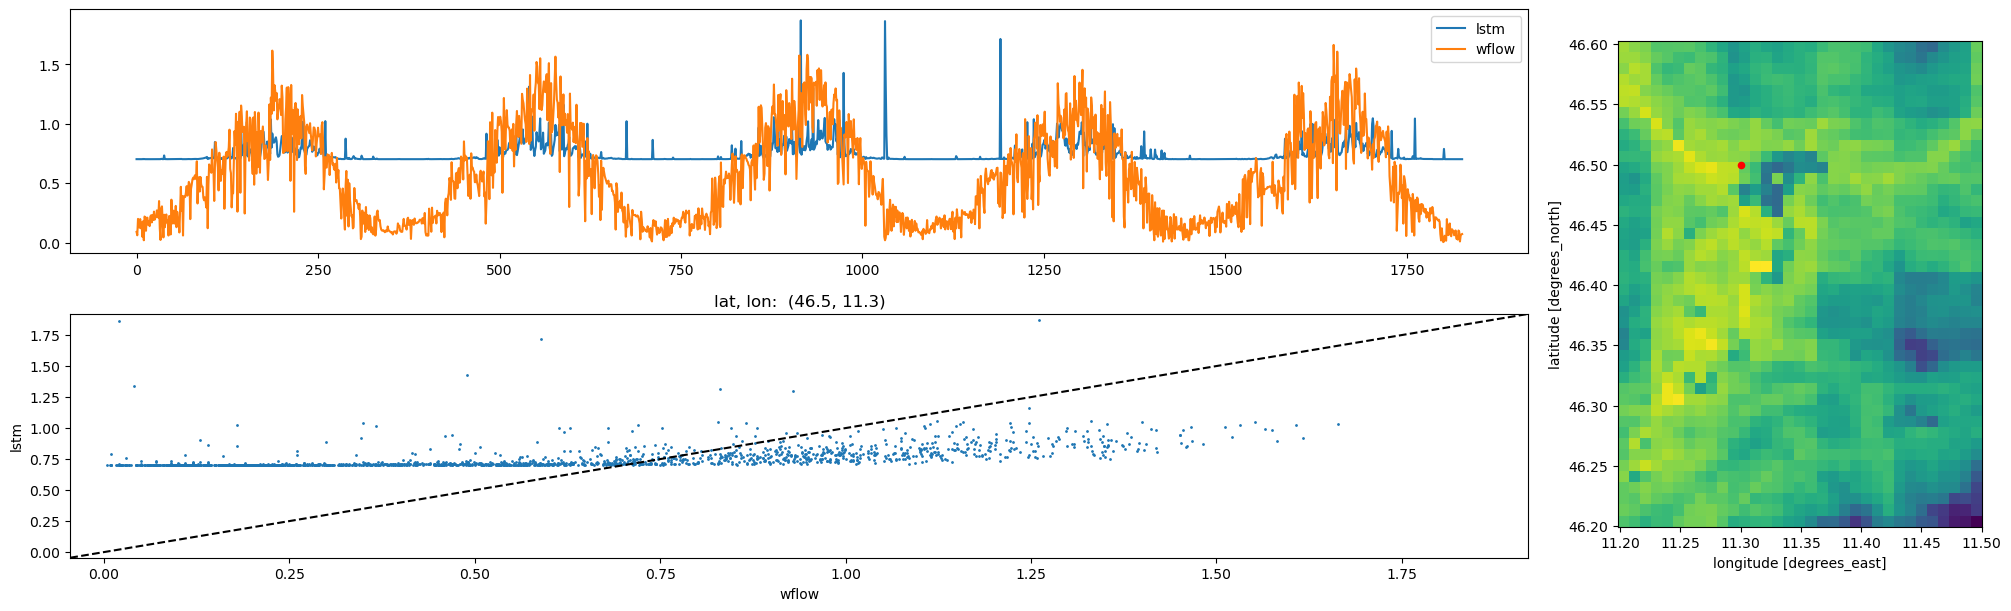

In [51]:
ts_compare(y_target, y_pred, lat = [46.4, 46.5], lon = [11.4, 11.3])

In [ ]:
# SpaceTime

In [71]:
from torch.utils.data import Dataset,DataLoader

In [108]:
class B(Dataset):

    def __init__(self,X):
        self.X = X

    def __getitem__(self, i, j):
        return self.X[i, j]
        
    def __len__(self):
        return self.X.shape[0]
    

In [109]:
d = B(np.arange(100).reshape(10,10))

In [107]:
dl = DataLoader(d, batch_size=7)

In [ ]:
for i in dl:
    print(i)

In [114]:
# https://discuss.pytorch.org/t/custom-dataset-with-getitem-method-that-requires-two-indices-as-input/62083/2